Project description
===

```
Here we have a dataset on a startup that sells food products. We want to explore users' behaviour patterns. 

First, we should do some data preprocessing: clean the data, fill in the missing values (if any), and change data types. Also, we need to add some new columns to help in our analysis. After doing so, we could explore our data.

```

**Description of the data**
```
/datasets/logs_exp_us.csv
    EventName — event name
    DeviceIDHash — unique user identifier
    EventTimestamp — event time
    ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group
```

## Open the data and study the general information

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import HTML, display_html
from IPython.core.interactiveshell import InteractiveShell

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 500) # columns number

In [4]:
logs_dtype = {'DeviceIDHash': 'uint64', 'ExpId': 'category', 'EventName': 'category'}

try:
    logs = pd.read_csv('./datasets/logs_exp_us.csv', sep='\t', dtype=logs_dtype)
except:
    logs = pd.read_csv('../datasets/logs_exp_us.csv', sep='\t', dtype=logs_dtype)

In [5]:
logs.columns = ['event', 'user_id', 'ev_dtime', 'group']
logs['ev_dtime'] = pd.to_datetime(logs['ev_dtime'], unit='s')
logs.info()
display(logs.describe(include = ['category']))
display(logs.sample(5))
print('Duplicates in data: {0} ({1:.2%})'.format(logs.duplicated().sum(), logs.duplicated().sum()/logs.shape[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     244126 non-null  category      
 1   user_id   244126 non-null  uint64        
 2   ev_dtime  244126 non-null  datetime64[ns]
 3   group     244126 non-null  category      
dtypes: category(2), datetime64[ns](1), uint64(1)
memory usage: 4.2 MB


,event,group
count,244126,244126
unique,5,3
top,MainScreenAppear,248
freq,119205,85747


,event,user_id,ev_dtime,group
140654,MainScreenAppear,5613440135781762576,2019-08-04 22:18:21,246
171613,OffersScreenAppear,4882051544540389942,2019-08-05 18:00:23,247
11745,MainScreenAppear,2563064043024540302,2019-08-01 09:15:06,247
43918,OffersScreenAppear,6421065471506532863,2019-08-02 06:01:47,246
113765,CartScreenAppear,197027893265565660,2019-08-04 08:01:12,246


Duplicates in data: 413 (0.17%)


**Conclusion**

There are no missing values in this dataset.

After the first investigation, we changed data types of `EventName` and `ExpId` to categories and downcasted `DeviceIDHash` to unsigned while reading from the file. Also, we changed the `EventTimestamp` column from timestamp to datetime and renamed the columns. 

We have a small number of duplicates (0.17%) in this dataset, which I assume is safe to drop.

## Data preprocessing

In [6]:
logs = logs.drop_duplicates()

logs['ev_date'] = logs['ev_dtime'].dt.date

logs['group'] = logs['group'].replace({'246': 'A1', '247': 'A2', '248': 'B'}).astype('category')  

badvisitors = logs.groupby(['user_id'], as_index=False).agg({'group': 'nunique'})
badvisitors = badvisitors[badvisitors['group']>1]
print('Number of users in several groups at the same time is {0:.0f}.'.format(badvisitors.shape[0]))

Number of users in several groups at the same time is 0.


**Conclusion**

We dropped duplicates and checked that we didn't have any users in several groups simultaneously.  
Also, I added a separate column for a date and changed the values indicating the group to be more human-readable.

## Analyze the data

### Study and check the data

#### How many events are in the logs?

In [7]:
numevents = logs.shape[0]
print('There are {0} events in logs.'.format(numevents))

There are 243713 events in logs.


---
#### How many users are in the logs?

In [8]:
numusers = logs['user_id'].nunique()
print('There are {0} users in logs.'.format(numusers))

There are 7551 users in logs.


---
#### What's the average number of events per user?

In [9]:
print('There average number of events per user is {0:.0f}.'.format(numevents/numusers))

There average number of events per user is 32.


,user_id,ev_dtime
count,7551.000,7551.000
mean,4677318727102441472.000,32.276
std,2655343100552021504.000,65.154
min,6888746892508752.000,1.000
25%,2397700422051031552.000,9.000
50%,4688021588771745792.000,20.000
75%,7007352523282521088.000,37.000
max,9222603179720523776.000,2307.000


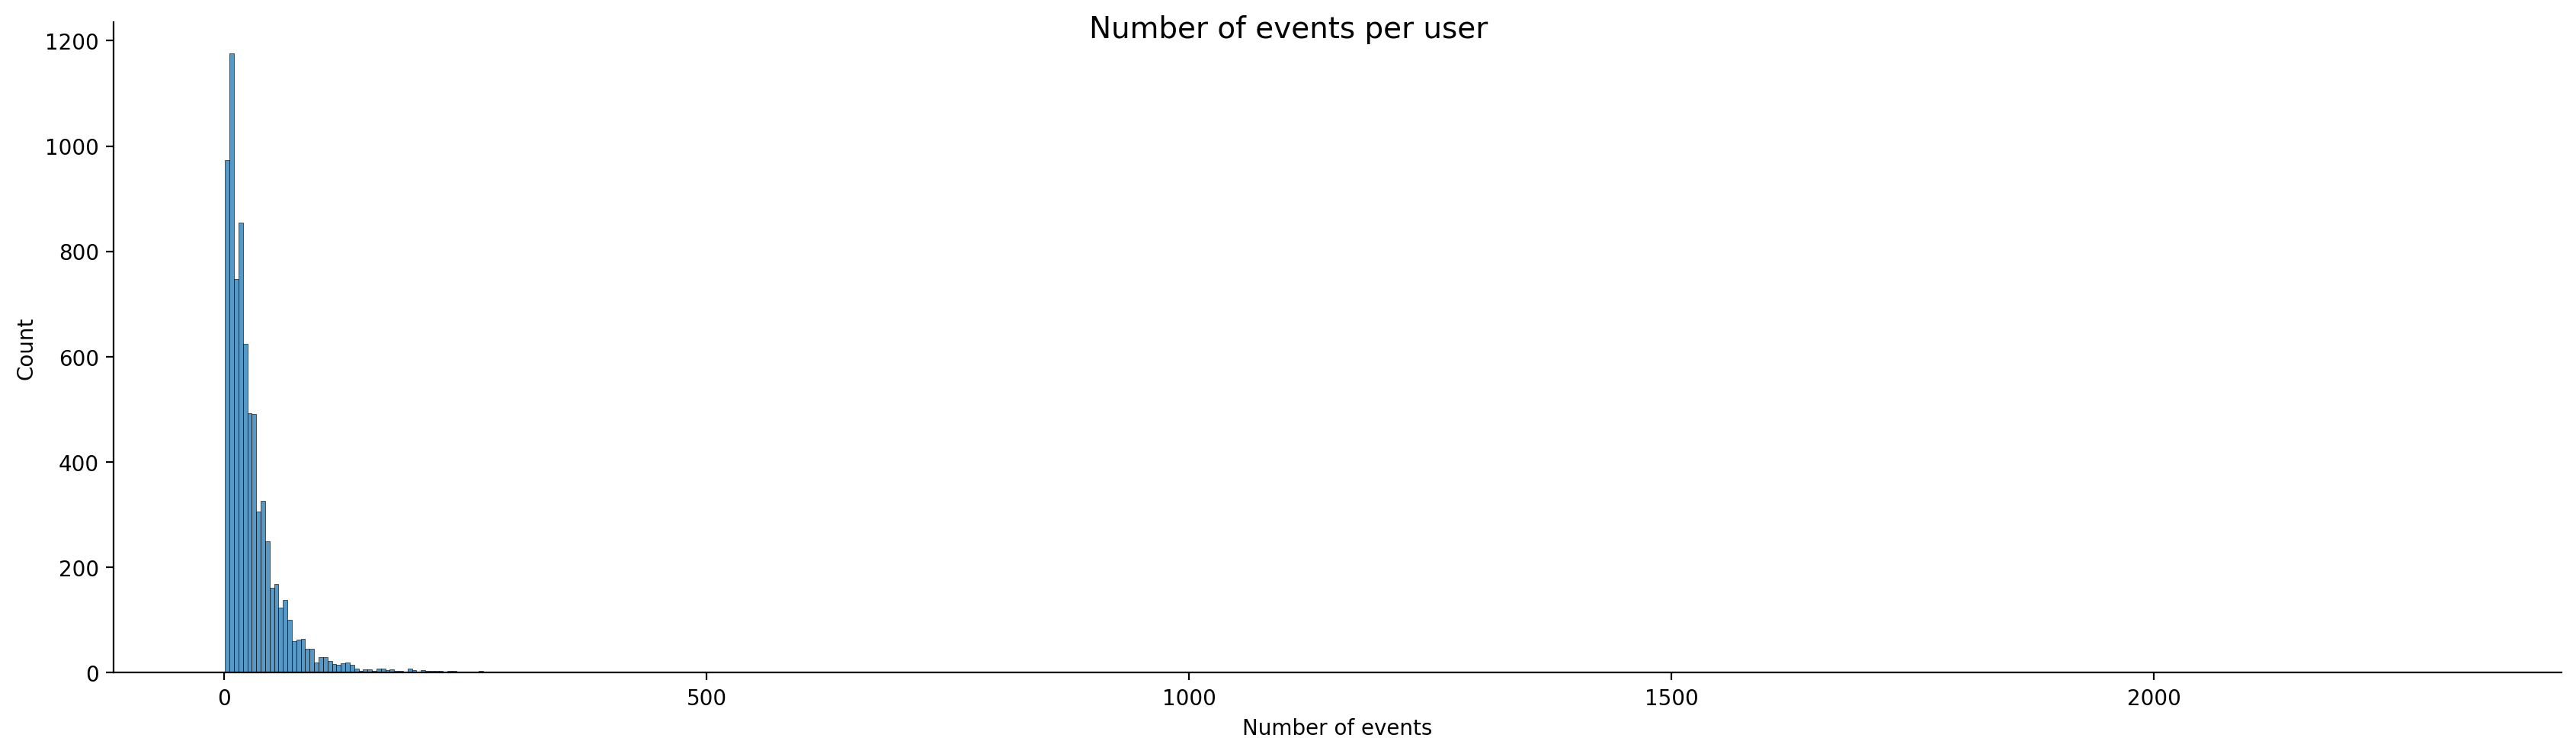

In [10]:
perusr = logs.groupby('user_id', as_index=False).agg({'ev_dtime':'count'})
display(perusr.describe())
g = sns.displot(data=perusr, x='ev_dtime', kind="hist", bins=500, height=5, aspect=17/5);
g.figure.suptitle("Number of events per user", fontsize=14);
g.set(xlabel='Number of events', ylabel='Count');
plt.show()

---
#### What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?

In [11]:
print('The dates range is from {0} to {1}.'.format(logs['ev_date'].min(), logs['ev_date'].max() ))

The dates range is from 2019-07-25 to 2019-08-07.


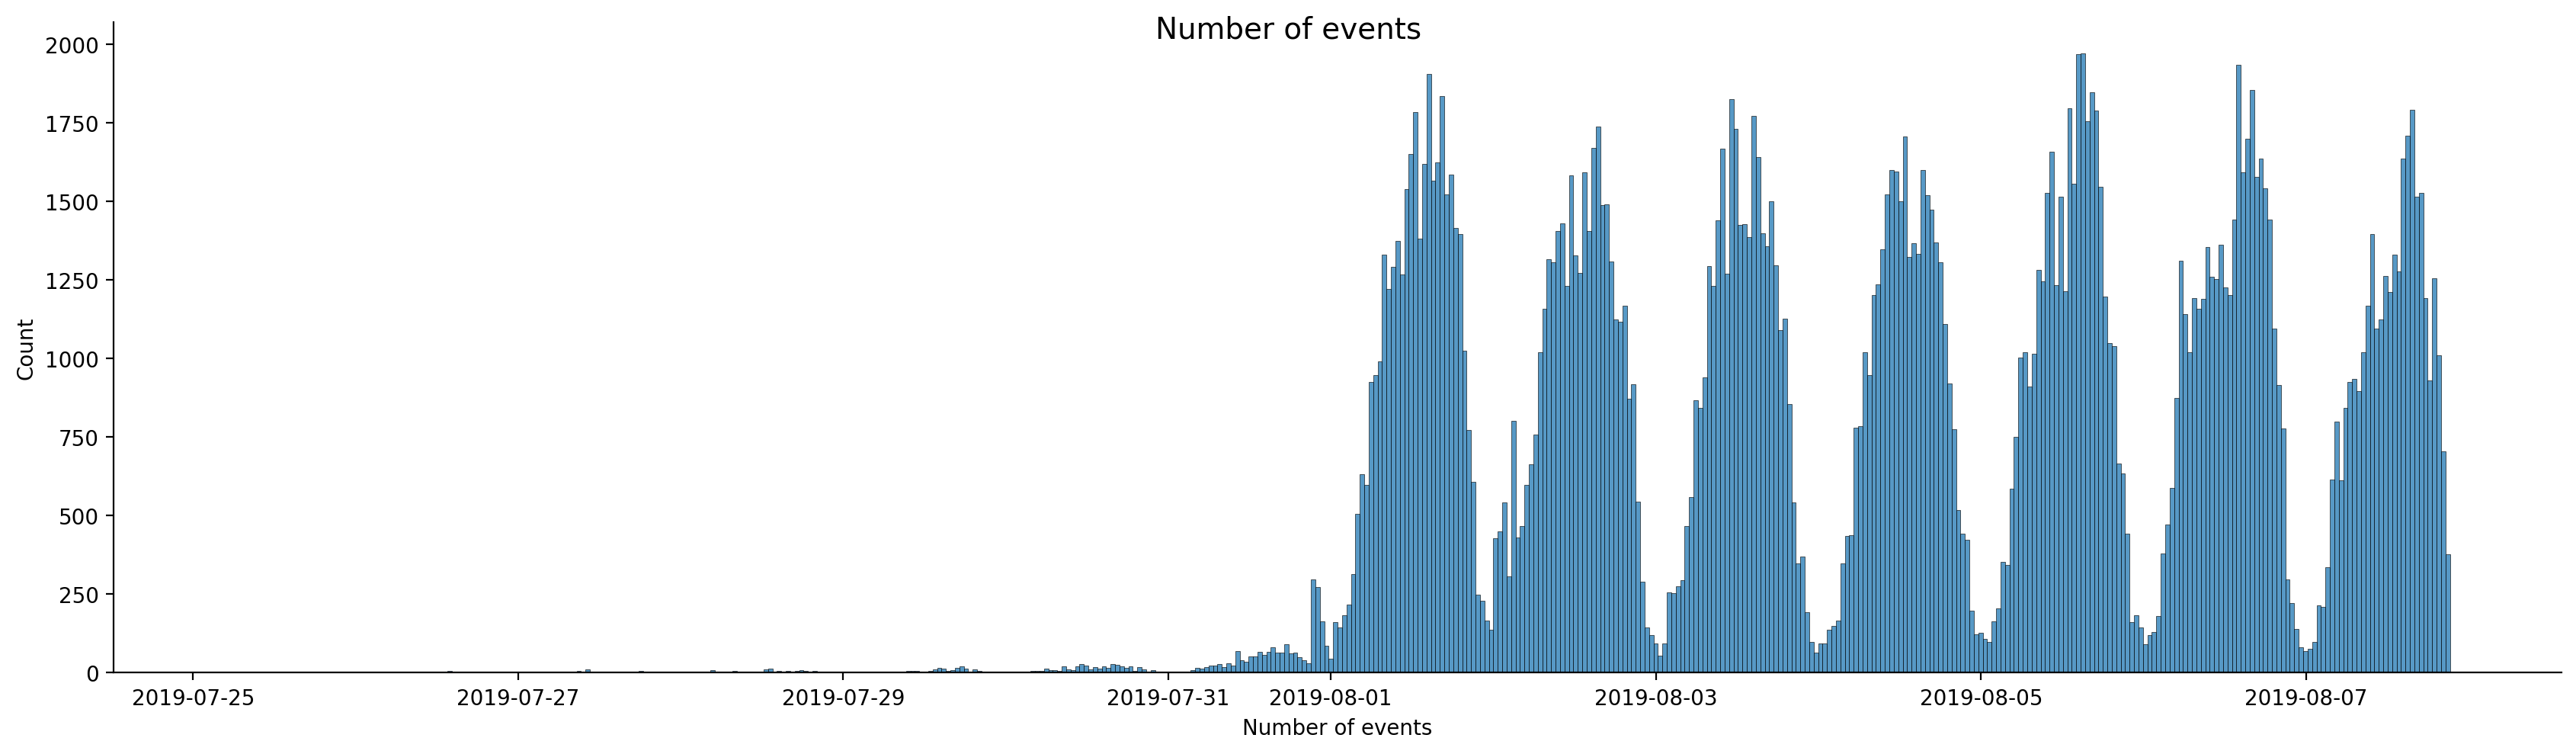

In [12]:
g = sns.displot(data=logs, x='ev_dtime', kind="hist", bins=500, height=5, aspect=17/5);
g.figure.suptitle("Number of events", fontsize=14);
g.set(xlabel='Number of events', ylabel='Count');
plt.show()

In [13]:
oldlogs = logs[logs['ev_dtime'] < pd.to_datetime('2019-08-01')]
logs = logs[~logs['user_id'].isin(oldlogs['user_id'].unique())]
print('The new dates range is from {0} to {1}.'.format(logs['ev_date'].min(), logs['ev_date'].max() ))

The new dates range is from 2019-08-01 to 2019-08-07.


**Conclusion**

The initial range of our data was from 2019-07-25 to 2019-08-07. But before 2019-08-01, we had very few data points. Thus it's better to exclude users who came before. So the new range is from 2019-08-01 to 2019-08-07.

---

#### Did you lose many events and users when excluding the older data?

In [14]:
print('We excluded {0} ({1:.2%}) users and {2} ({3:.2%}) events.'\
      .format(oldlogs['user_id'].nunique(), oldlogs['user_id'].nunique()/numusers,\
              numevents-logs.shape[0], (numevents-logs.shape[0])/numevents))

We excluded 1451 (19.22%) users and 60057 (24.64%) events.


---
#### Make sure you have users from all three experimental groups.

In [15]:
logs.groupby(['group'])['user_id'].count()

group
A1    59622
A2    58630
B     65404
Name: user_id, dtype: int64

---
### Study the event funnel
#### See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [16]:
ev_freq = logs.groupby('event', as_index=False).agg({'ev_dtime':'count',})\
              .rename(columns={'ev_dtime':'num_events',})\
              .sort_values(['num_events'], ascending=False)

ev_freq['ev_prop'] = ev_freq['num_events']/logs.shape[0]
ev_freq.style.hide(axis='index').format(precision=2, formatter={'ev_prop': "{:.2%}",})

event,num_events,ev_prop
MainScreenAppear,88829,48.37%
OffersScreenAppear,35950,19.57%
CartScreenAppear,32265,17.57%
PaymentScreenSuccessful,25621,13.95%
Tutorial,991,0.54%


**Conclusion**  
Almost half of the events are `MainScreenAppear`, and `Tutorial` is less than 1%.

---

#### Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.

In [17]:
ev_us_freq = logs.groupby('event', as_index=False).agg({'user_id':'nunique'})\
                 .rename(columns={'user_id': 'num_users'})\
                 .sort_values(['num_users'], ascending=False)

ev_us_freq['user_prop'] = ev_us_freq['num_users']/logs['user_id'].nunique()
ev_us_freq.style.hide(axis='index').format(precision=2, formatter={'user_prop': "{:.2%}",})

event,num_users,user_prop
MainScreenAppear,6017,98.64%
OffersScreenAppear,3739,61.30%
CartScreenAppear,3014,49.41%
PaymentScreenSuccessful,2852,46.75%
Tutorial,829,13.59%


**Conclusion**  
Counting unique users, we could see that almost all of them saw the `MainScreenAppear`, and 13.5% saw the `Tutorial`.

---

#### In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.

In [18]:
logs = logs[logs['event'] != 'Tutorial']
logs['event'] = logs['event'].cat.remove_categories(['Tutorial'])

**Conclusion**  
The `Tutorial` event doesn't look like a necessary part of a buying sequence. Therefore we could exclude it from the event fennel.

---

#### Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)

#### At what stage do you lose the most users?

In [19]:
funnel = logs.groupby(['event'])['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel['change']=funnel['user_id'].pct_change()
funnel.style.hide(axis='index').format(precision=2, formatter={'change': "{:.2%}",})

event,user_id,change
MainScreenAppear,6017,nan%
OffersScreenAppear,3739,-37.86%
CartScreenAppear,3014,-19.39%
PaymentScreenSuccessful,2852,-5.37%


**Conclusion**  
We lost the most share of users (38%) between the `MainScreenAppear` and `OffersScreenAppear`.

---

#### What share of users make the entire journey from their first event to payment?

In [20]:
print('{0:.0%} of users made the journey from MainScreenAppear to PaymentScreenSuccessful.'\
      .format(logs[logs['event']=='PaymentScreenSuccessful']['user_id'].nunique()\
              /logs[logs['event']=='MainScreenAppear']['user_id'].nunique()))

47% of users made the journey from MainScreenAppear to PaymentScreenSuccessful.


---

In [21]:
funnel_by_groups = []

for i in logs['group'].unique():
    group = logs[logs.group==i].groupby(['event','group'], as_index=False, observed=True)['user_id'].nunique()\
                               .sort_values(by='user_id', ascending=False)
    funnel_by_groups.append(group)
    
funnel_by_groups = pd.concat(funnel_by_groups)   

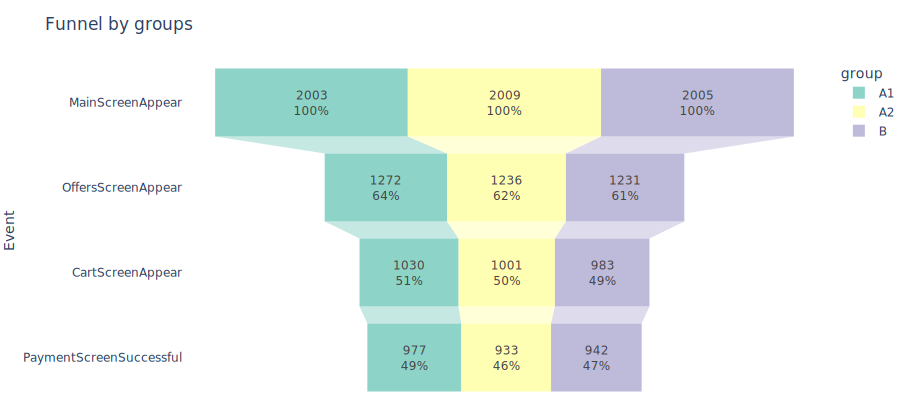

In [22]:
fig = px.funnel(funnel_by_groups, x='user_id', y='event', color='group',
                color_discrete_sequence=px.colors.qualitative.Set3)\
        .update_traces(hovertemplate=None, textinfo='value+percent initial')\
        .update_layout(margin=dict(l=10, r=10, b=0), template='plotly_white', 
                       yaxis_title_text='Event', 
                       title='Funnel by groups',
                       width=900, height=400, 
                      )
fig.show('svg')

**Conclusion**  
The share of the users who came through the event funnel looks not significantly different between all three groups. Let's confirm or disprove this using statistical tests.

---

### Study the results of the experiment
#### How many users are there in each group?

In [23]:
logs.groupby(['group'])['user_id'].nunique()

group
A1    2029
A2    2035
B     2032
Name: user_id, dtype: int64

---

#### We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.

In [24]:
def testing_proportion(logs, pivot, trials1, trials2, event, group1, group2, alpha=0.05):
    successes1 = pivot[pivot['event']==event][group1].iloc[0]
    successes2 = pivot[pivot['event']==event][group2].iloc[0]
        
    print(f'Trials Group {group1}: {trials1}')
    print(f'Successes Group {group1}: {successes1}')
    print(f'Proportion Group {group1}: {successes1/trials1:0.3f}')
    print()    

    print(f'Trials Group {group2}: {trials2}')
    print(f'Successes Group {group2}: {successes2}')
    print(f'Proportion Group {group2}: {successes2/trials2:0.3f}')
    print()    

    
    statist, p_value = proportions_ztest([successes1, successes2], [trials1, trials2])
    print(f'P-value: {p_value:0.3f}')
    if p_value < alpha:
        print(f'Reject H0 for {event} in groups {group1} and {group2}')
    else:
        print(f'Failed to reject H0 for {event} in groups {group1} and {group2}')
               

alpha = 0.05

95% statistical significance level (alpha 0.05) would be enough for our tests.

In [25]:
pivot = logs.pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique')\
            .reset_index().sort_values('A1', ascending=False)

pivot['A1+A2'] = pivot['A1'] + pivot['A2']
pivot.style.hide(axis='index')

event,A1,A2,B,A1+A2
MainScreenAppear,2003,2009,2005,4012
OffersScreenAppear,1272,1236,1231,2508
CartScreenAppear,1030,1001,983,2031
PaymentScreenSuccessful,977,933,942,1910


#### Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?

*Null hypothesis:* There are no statistically significant differences in proportions between the groups for each event.  
*Alternative hypothesis:* There is a statistically significant difference in proportions between the groups for each event. 

In [26]:
trials1 = logs[logs['group']=='A1']['user_id'].nunique()
trials2 = logs[logs['group']=='A2']['user_id'].nunique()


for event in pivot['event'].unique():
    display_html(f'<b>Testing groups A1 and A2 for event {event}</b>', raw = True)    
    testing_proportion(logs, pivot, trials1, trials2, event, 'A1', 'A2', alpha=alpha)
    print()

Testing groups A1 and A2 for event MainScreenAppear

Trials Group A1: 2029
Successes Group A1: 2003
Proportion Group A1: 0.987

Trials Group A2: 2035
Successes Group A2: 2009
Proportion Group A2: 0.987

P-value: 0.991
Failed to reject H0 for MainScreenAppear in groups A1 and A2



Testing groups A1 and A2 for event OffersScreenAppear

Trials Group A1: 2029
Successes Group A1: 1272
Proportion Group A1: 0.627

Trials Group A2: 2035
Successes Group A2: 1236
Proportion Group A2: 0.607

P-value: 0.200
Failed to reject H0 for OffersScreenAppear in groups A1 and A2



Testing groups A1 and A2 for event CartScreenAppear

Trials Group A1: 2029
Successes Group A1: 1030
Proportion Group A1: 0.508

Trials Group A2: 2035
Successes Group A2: 1001
Proportion Group A2: 0.492

P-value: 0.315
Failed to reject H0 for CartScreenAppear in groups A1 and A2



Testing groups A1 and A2 for event PaymentScreenSuccessful

Trials Group A1: 2029
Successes Group A1: 977
Proportion Group A1: 0.482

Trials Group A2: 2035
Successes Group A2: 933
Proportion Group A2: 0.458

P-value: 0.141
Failed to reject H0 for PaymentScreenSuccessful in groups A1 and A2



**Conclusion**  
Comparing two control groups, we failed to reject the null hypothesis that there are no statistically significant differences in proportions for each event. 

---

#### Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

*Null hypothesis:* There are no statistically significant differences in proportions between the groups for each event.  
*Alternative hypothesis:* There is a statistically significant difference in proportions between the groups for each event. 

In [27]:
trials1 = logs[logs['group']=='A1']['user_id'].nunique()
trials2 = logs[logs['group']=='B']['user_id'].nunique()

for event in pivot['event'].unique():
    display_html(f'<b>Testing groups A1 and B for event {event}</b>', raw = True)    
    testing_proportion(logs, pivot, trials1, trials2, event, 'A1', 'B', alpha=alpha)
    print()    

Testing groups A1 and B for event MainScreenAppear

Trials Group A1: 2029
Successes Group A1: 2003
Proportion Group A1: 0.987

Trials Group B: 2032
Successes Group B: 2005
Proportion Group B: 0.987

P-value: 0.894
Failed to reject H0 for MainScreenAppear in groups A1 and B



Testing groups A1 and B for event OffersScreenAppear

Trials Group A1: 2029
Successes Group A1: 1272
Proportion Group A1: 0.627

Trials Group B: 2032
Successes Group B: 1231
Proportion Group B: 0.606

P-value: 0.167
Failed to reject H0 for OffersScreenAppear in groups A1 and B



Testing groups A1 and B for event CartScreenAppear

Trials Group A1: 2029
Successes Group A1: 1030
Proportion Group A1: 0.508

Trials Group B: 2032
Successes Group B: 983
Proportion Group B: 0.484

P-value: 0.128
Failed to reject H0 for CartScreenAppear in groups A1 and B



Testing groups A1 and B for event PaymentScreenSuccessful

Trials Group A1: 2029
Successes Group A1: 977
Proportion Group A1: 0.482

Trials Group B: 2032
Successes Group B: 942
Proportion Group B: 0.464

P-value: 0.252
Failed to reject H0 for PaymentScreenSuccessful in groups A1 and B



In [28]:
trials1 = logs[logs['group']=='A2']['user_id'].nunique()
trials2 = logs[logs['group']=='B']['user_id'].nunique()

for event in pivot['event'].unique():
    display_html(f'<b>Testing groups A2 and B for event {event}</b>', raw = True)    
    testing_proportion(logs, pivot, trials1, trials2, event, 'A2', 'B', alpha=alpha)
    print()    

Testing groups A2 and B for event MainScreenAppear

Trials Group A2: 2035
Successes Group A2: 2009
Proportion Group A2: 0.987

Trials Group B: 2032
Successes Group B: 2005
Proportion Group B: 0.987

P-value: 0.886
Failed to reject H0 for MainScreenAppear in groups A2 and B



Testing groups A2 and B for event OffersScreenAppear

Trials Group A2: 2035
Successes Group A2: 1236
Proportion Group A2: 0.607

Trials Group B: 2032
Successes Group B: 1231
Proportion Group B: 0.606

P-value: 0.919
Failed to reject H0 for OffersScreenAppear in groups A2 and B



Testing groups A2 and B for event CartScreenAppear

Trials Group A2: 2035
Successes Group A2: 1001
Proportion Group A2: 0.492

Trials Group B: 2032
Successes Group B: 983
Proportion Group B: 0.484

P-value: 0.604
Failed to reject H0 for CartScreenAppear in groups A2 and B



Testing groups A2 and B for event PaymentScreenSuccessful

Trials Group A2: 2035
Successes Group A2: 933
Proportion Group A2: 0.458

Trials Group B: 2032
Successes Group B: 942
Proportion Group B: 0.464

P-value: 0.744
Failed to reject H0 for PaymentScreenSuccessful in groups A2 and B



In [29]:
trials1 = logs[(logs['group']=='A1') | (logs['group']=='A2')]['user_id'].nunique()
trials2 = logs[logs['group']=='B']['user_id'].nunique()

for event in pivot['event'].unique():
    display_html(f'<b>Testing groups A1+A2 and B for event {event}</b>', raw = True)    
    testing_proportion(logs, pivot, trials1, trials2, event, 'A1+A2', 'B', alpha=alpha)
    print()    

Testing groups A1+A2 and B for event MainScreenAppear

Trials Group A1+A2: 4064
Successes Group A1+A2: 4012
Proportion Group A1+A2: 0.987

Trials Group B: 2032
Successes Group B: 2005
Proportion Group B: 0.987

P-value: 0.873
Failed to reject H0 for MainScreenAppear in groups A1+A2 and B



Testing groups A1+A2 and B for event OffersScreenAppear

Trials Group A1+A2: 4064
Successes Group A1+A2: 2508
Proportion Group A1+A2: 0.617

Trials Group B: 2032
Successes Group B: 1231
Proportion Group B: 0.606

P-value: 0.392
Failed to reject H0 for OffersScreenAppear in groups A1+A2 and B



Testing groups A1+A2 and B for event CartScreenAppear

Trials Group A1+A2: 4064
Successes Group A1+A2: 2031
Proportion Group A1+A2: 0.500

Trials Group B: 2032
Successes Group B: 983
Proportion Group B: 0.484

P-value: 0.239
Failed to reject H0 for CartScreenAppear in groups A1+A2 and B



Testing groups A1+A2 and B for event PaymentScreenSuccessful

Trials Group A1+A2: 4064
Successes Group A1+A2: 1910
Proportion Group A1+A2: 0.470

Trials Group B: 2032
Successes Group B: 942
Proportion Group B: 0.464

P-value: 0.637
Failed to reject H0 for PaymentScreenSuccessful in groups A1+A2 and B



**Conclusion**  
Comparing the test group with both control groups separately and combined, we failed to reject the null hypothesis that there are no statistically significant differences in proportions for each event. So it looks like there is no distinction between all the groups, and changing the font didn't alter users' behaviour.

---

#### What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

In [30]:
fwer = 1 - (1 - alpha) ** 16
print(f'Family-wise error rate for our 16 hypothesis tests is {fwer:0.0%}')

Family-wise error rate for our 16 hypothesis tests is 56%


**Conclusion**  
Running several tests on the same data increases the probability of making a type I error. So if we were most worried about rejecting a true null hypothesis, we should correct the alpha value and rerun the tests. But since we failed to reject any of our hypotheses, there is no need for this.

---

## Overall conclusion

We have a dataset logged events of a startup that sells food products. After changing data types and dropping duplicates, we checked that we didn't have any users in several groups simultaneously and made the group value human-readable.

Investigating the data, we found that our logs start on 2019-07-25, but part of the data before 2019-08-01 looks incomplete. So we excluded about 25% of the events.

Also, judging from the data, we concluded that the `Tutorial` didn't belong to the event funnel and excluded it.

While 47% of users made the entire journey from `MainScreenAppear` to `PaymentScreenSuccessful`, we lost the most share (38%) between the `MainScreenAppear` and `OffersScreenAppear`.

We failed to see any significant difference between the groups plotting the event funnel and running tests on the proportions.
Changing the font didn't make any difference; all three groups belong to the same statistical population.

Since after the `MainScreenAppear` we lost almost twice as many users as after `OffersScreenAppear`, I suggest looking for possible improvements on the main screen. For example, adding special offers (instead of the dedicated screen) could boost purchases.